In [5]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [8]:
video_path = "/home/ducle/Downloads/Thanh Hóa_ Hàng nghìn giáo viên thấp thỏm vì nợ lương, hết hạn hợp đồng _ VTV24.mp4"

In [9]:
from scenedetect import detect, ContentDetector
import cv2
def detect_scenes(video_path):
    scene_list = detect(video_path, ContentDetector())
    info = {}
    # get total number of frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # get duration of video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    duration = total_frames / fps
    info['total_frames'] = total_frames
    info['duration'] = duration
    # get scene list
    frame_list = []
    time_list = []
    for i, scene in enumerate(scene_list):
        start_frame = scene[0].get_frames()
        end_frame = scene[1].get_frames()
        start_time = scene[0].get_timecode()
        end_time = scene[1].get_timecode()
        frame_list.append((start_frame, end_frame))
        time_list.append((start_time, end_time))
    info['frame_list'] = frame_list
    info['time_list'] = time_list
    
    return info

In [10]:
frame_list = detect_scenes(video_path)
mid_frames = [(start + end) // 2 for start, end in frame_list['frame_list']]

In [6]:
# split into clip
import cv2 
import os
scene_path = "scene"
if not os.path.exists(scene_path):
    os.makedirs(scene_path)

num_clips = len(frame_list['frame_list'])
for i in range(num_clips):
    start_frame, end_frame = frame_list['frame_list'][i]
    mid_frame = mid_frames[i]
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    out = cv2.VideoWriter(f"{scene_path}/clip_{i}.mp4", 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          30, (int(cap.get(3)), int(cap.get(4))))
    
    for frame_num in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
    
    out.release()
    cap.release()


[h264 @ 0x1373de80] mmco: unref short failure
[h264 @ 0x1373de80] mmco: unref short failure


In [11]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np

# Load the CLIP model and processor once
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

def encode_frame_to_vector(frame):
    """
    Encodes an image frame into a vector using Hugging Face's CLIP model.

    Args:
        frame (PIL.Image.Image or np.ndarray): The input image frame.

    Returns:
        torch.Tensor: The image embedding vector (shape: [1, embedding_dim]).
    """
    # Convert NumPy array to PIL Image if needed
    if isinstance(frame, np.ndarray):
        frame = Image.fromarray(frame)

    # Preprocess the frame
    inputs = clip_processor(images=frame, return_tensors="pt")

    # Get image embedding
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)

    # Normalize the vector
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

    return image_features


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
features = []
import cv2
def extract_frame(video_path, frame_number):
    """
    Extracts a specific frame from a video file.

    Args:
        video_path (str): Path to the video file.
        frame_number (int): The frame number to extract.

    Returns:
        np.ndarray: The extracted frame as a NumPy array.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        raise ValueError(f"Could not read frame {frame_number} from video.")
    
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
for frame_number in mid_frames:
    frame = extract_frame(video_path, frame_number)
    feature = encode_frame_to_vector(frame)
    features.append(feature)


[h264 @ 0x19678680] mmco: unref short failure
[h264 @ 0x19678680] mmco: unref short failure
[h264 @ 0x1af576c0] mmco: unref short failure
[h264 @ 0x1af576c0] mmco: unref short failure


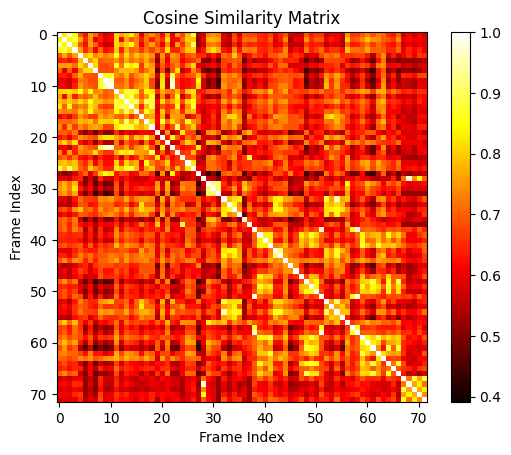

In [13]:
import matplotlib.pyplot as plt

# show the correlation between the features by cosine similarity
def cosine_similarity(a, b):
    """
    Computes the cosine similarity between two vectors.

    Args:
        a (torch.Tensor): First vector.
        b (torch.Tensor): Second vector.

    Returns:
        float: Cosine similarity value.
    """
    return torch.nn.functional.cosine_similarity(a, b).item()

def plot_similarity_matrix(features):
    """
    Plots a similarity matrix for the given features.

    Args:
        features (list of torch.Tensor): List of feature vectors.
    """
    num_features = len(features)
    similarity_matrix = np.zeros((num_features, num_features))

    for i in range(num_features):
        for j in range(num_features):
            similarity_matrix[i, j] = cosine_similarity(features[i], features[j])

    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Cosine Similarity Matrix')
    plt.xlabel('Frame Index')
    plt.ylabel('Frame Index')
    plt.show()
plot_similarity_matrix(features)

In [14]:
# group  consecutive frames with cosine similarity > 0.8
import numpy as np
def group_similar_frames(features, threshold=0.8, max_gap=1):
    
    groups = list()
    c_group = list()
    idx = -1
    while(idx<len(features)-1):
        idx+=1

        if len(c_group)==0:
            c_group.append(idx)
            continue 
        sim = np.dot(features[idx], features[idx-1].reshape(-1))

        if sim>=threshold:
            c_group.append(idx)
            continue 
        else:
            flag = False
            for i in range(max_gap):
                for j in c_group:
                    if not i+idx>=len(features): 
                        _sim = np.dot(features[j],features[idx+i].reshape(-1))
                        if _sim[0]>=threshold:
                            flag = True 
                            for ii in range(i):
                                idx+=ii
                                c_group.append(idx)
                            break 
                
                if flag:
                    break 
            if not flag:
                # print(groups)
                groups.append(c_group)
                c_group = list()
                c_group.append(idx)
    return groups
groups = group_similar_frames(features, threshold=0.75, max_gap=2) 
groups                  
            
            



/tmp/ipykernel_248944/2920549156.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  sim = np.dot(features[idx], features[idx-1].reshape(-1))
/tmp/ipykernel_248944/2920549156.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  _sim = np.dot(features[j],features[idx+i].reshape(-1))


[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  9,
  10,
  12,
  13,
  14,
  15,
  18,
  19,
  26,
  28,
  30,
  31,
  33,
  34,
  35],
 [38],
 [39, 40, 41],
 [42, 43, 44, 45],
 [46],
 [47, 48, 49, 50],
 [51],
 [52, 53, 54, 55],
 [57, 58],
 [59, 60, 61, 63]]

In [1]:
# captioning 
import torch
from transformers import pipeline

pipeline = pipeline(
    task="image-text-to-text",
    model="google/gemma-3-4b-pt",
    device=0,
    torch_dtype=torch.bfloat16
)
pipeline(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg",
    text="<start_of_image> What is shown in this image?"
)

/home/ducle/miniconda3/envs/rl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/gemma-3-4b-pt.
401 Client Error. (Request ID: Root=1-6835949e-4a6479395e72b39d2cf49c47;8e2f5f5b-3a01-4f95-aa0c-6d803d093010)

Cannot access gated repo for url https://huggingface.co/google/gemma-3-4b-pt/resolve/main/config.json.
Access to model google/gemma-3-4b-pt is restricted. You must have access to it and be authenticated to access it. Please log in.

In [15]:
similar_frame_groups = groups


In [16]:
# group the start and end frames of each group
def group_frame_ranges(groups, frame_list):
    """
    Groups the start and end frames of each group.

    Args:
        groups (list of list): List of groups of similar frames.
        frame_list (list of tuple): List of tuples containing start and end frames.

    Returns:
        list of tuple: List of tuples containing start and end frames for each group.
    """
    grouped_ranges = []
    
    for group in groups:
        if group:
            start_frame = frame_list[group[0]][0]
            end_frame = frame_list[group[-1]][1]
            grouped_ranges.append((start_frame, end_frame))
    
    return grouped_ranges
grouped_ranges = group_frame_ranges(similar_frame_groups, frame_list['frame_list'])
grouped_ranges

[(0, 4258),
 (4681, 5133),
 (5133, 5266),
 (5266, 5430),
 (5430, 5496),
 (5496, 5802),
 (5802, 6430),
 (6430, 6698),
 (6956, 7864),
 (7864, 8133)]

In [17]:

num_clips = len(grouped_ranges)
for i in range(num_clips):
    start_frame, end_frame = fgrouped_ranges[i]
    mid_frame = mid_frames[i]
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    out = cv2.VideoWriter(f"{scene_path}/clip_{i}.mp4", 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          30, (int(cap.get(3)), int(cap.get(4))))
    
    for frame_num in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
    
    out.release()
    cap.release()


NameError: name 'fgrouped_ranges' is not defined

In [ ]:
import unicodedata

def remove_vietnamese_accents(text):
    """
    Convert Vietnamese text to unsigned characters by removing accents.

    Args:
        text (str): The input Vietnamese text.

    Returns:
        str: Text with accents removed.
    """
    text = unicodedata.normalize('NFD', text)
    text = ''.join(char for char in text if unicodedata.category(char) != 'Mn')
    return text

out_video_path = remove_vietnamese_accents(video_path)

In [98]:
import os 
video_name  = os.path.basename(video_path)
video_name

'Thanh Hóa_ Hàng nghìn giáo viên thấp thỏm vì nợ lương, hết hạn hợp đồng _ VTV24.mp4'

In [99]:

# write to video, denote the start and end frames of each group
def write_grouped_video(video_path, grouped_ranges, output_path):
    """
    Writes a new video file with highlighted groups of frames.

    Args:
        video_path (str): Path to the input video file.
        grouped_ranges (list of tuple): List of tuples containing start and end frames for each group.
        output_path (str): Path to save the output video file.
    """
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        for start, end in grouped_ranges:
            if start <= frame_count <= end:
                cv2.putText(frame, f"Group: {start}-{end}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        for start, end in frame_list['frame_list']:
            if start <= frame_count <= end:
                cv2.putText(frame, f"Original: {start}-{end}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()
output_video_path = f"grouped_video_{video_name}.mp4"
write_grouped_video(video_path, grouped_ranges, output_video_path)


In [100]:
# write original video with original start and end frames

def write_original_video(video_path, frame_list, output_path):
    """
    Writes a new video file with original start and end frames highlighted.

    Args:
        video_path (str): Path to the input video file.
        frame_list (list of tuple): List of tuples containing start and end frames.
        output_path (str): Path to save the output video file.
    """
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        for start, end in frame_list['frame_list']:
            if start <= frame_count <= end:
                cv2.putText(frame, f"Original: {start}-{end}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()
original_video_path = f"original_video_{video_name}.mp4
write_original_video(video_path, frame_list, original_video_path)

SyntaxError: unterminated string literal (detected at line 35) (4158683177.py, line 35)